In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.efm as exp_efm

# truncation

In [17]:
dim = 1
n = 500

X_ls = []
pval_ls_imq = []
pval_ls_tilted = []
pval_ls_boot = []
for trunc in [False, True]:
    np.random.seed(54321)
    
    ###
    X = jnp.array(np.random.normal(np.zeros((dim,)), size=(n, dim)))
    if trunc:
        X = jnp.round(X, 1)
    
    X_ls.append(X)
    
    score_fn = lambda x: - x
    ###
    
    # IMQ
    kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
    
    ksd = metrics.KSD(kernel, score_fn=score_fn)
    wild_boot = boot.WildBootstrap(ksd)
    pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
    
    pval_ls_imq.append(float(pval))

In [18]:
pval_ls_imq

[0.2407592386007309, 0.21178820729255676]

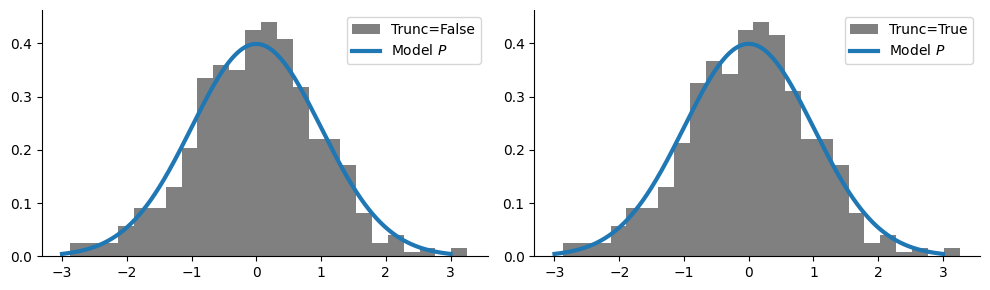

In [10]:
_, axes = plt.subplots(ncols=2, figsize=(10, 3))

xvals = jnp.linspace(-3., 3., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

# pvals_df = pd.DataFrame({"IMQ": pval_ls_imq, "Tilted": pval_ls_tilted}, index=["Without", "With"])

for i, trunc in enumerate([False, True]):
    ax = axes[i]
    ax.hist(X_ls[i].reshape(-1), bins=25, color="grey", density=True, label=f"Trunc={trunc}")
    # ax.get_yaxis().set_visible(False)

    ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    
    ax.legend()

plt.tight_layout()
# plt.savefig("../figs/robust/ucl_fig.pdf")

# OL

In [143]:
dim = 1
n = 500
nreps = 100
ol_mean = 10.
eps_ls = [0., 0.01]

Xs_ls = []
pval_ls_imq = []
pval_ls_tilted = []
pval_ls_boot = []
for eps in eps_ls:
    np.random.seed(54321)
    
    ###
    mean1 = np.zeros((dim,)) # data
    mean2 = np.zeros((dim,)) # model
    
    Xs = jnp.array(np.random.normal(mean1, size=(nreps, n, dim)))
    n_outlier = int(n * eps)
    Xs = jax.vmap(lambda x: exp_efm.sample_outlier_contam(x, eps, ol_mean, 0.1))(Xs)

    Xs_ls.append(Xs)
    
    score_fn = lambda x: - (x - mean2)
    ###
    
    # # IMQ
    # kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
    
    # ksd = metrics.KSD(kernel, score_fn=score_fn)
    # wild_boot = boot.WildBootstrap(ksd)
    # pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
    
    # pval_ls_imq.append(float(pval))

    # R-KSD boot
    score = score_fn(Xs)
    hvp = - score

    hvp_denom_sup = 1.
    theta = 0.1
    res = exp_utils.run_tests(
        samples=Xs, scores=score, hvps=hvp, hvp_denom_sup=hvp_denom_sup, 
        theta="ol", eps0=0.1, bw="med", alpha=0.05, verbose=True,
    )
    pval_ls_imq.append(res["standard"]["pval"])
    pval_ls_tilted.append(res["tilted"]["pval"])
    pval_ls_boot.append(res["tilted_r_boot"]["pval"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


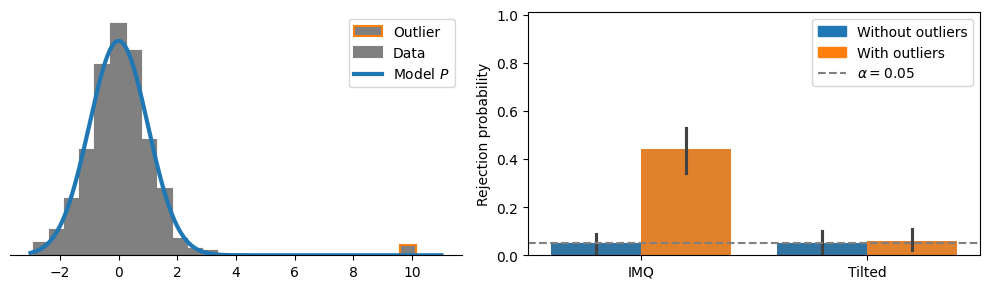

In [141]:
from pylab import setp
import matplotlib


# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    c1, c2 = "C0", "C1"
    setp(bp['boxes'][0], color=c1, linewidth=2)
    setp(bp['caps'][0], color=c1, linewidth=2)
    setp(bp['caps'][1], color=c1, linewidth=2)
    setp(bp['whiskers'][0], color=c1, linewidth=2)
    setp(bp['whiskers'][1], color=c1, linewidth=2)
    # setp(bp['fliers'][0], color=c1)
    # setp(bp['fliers'][1], color=c1)
    setp(bp['medians'][0], color=c1, linewidth=2)

    setp(bp['boxes'][1], color=c2, linewidth=2)
    setp(bp['caps'][2], color=c2, linewidth=2)
    setp(bp['caps'][3], color=c2, linewidth=2)
    setp(bp['whiskers'][2], color=c2, linewidth=2)
    setp(bp['whiskers'][3], color=c2, linewidth=2)
    setp(bp['medians'][1], color=c2, linewidth=2)

_, axes = plt.subplots(ncols=2, figsize=(10, 3))

bins = np.histogram(np.hstack(
    (X_ls[0].reshape(-1), X_ls[1].reshape(-1))
), bins=25)[1]

xvals = jnp.linspace(-3., ol_mean+1., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

# hist plots
ax = axes[0]
ax.hist(X_ls[1].reshape(-1), bins, color="grey", density=True, edgecolor="C1", linewidth=1.5, label="Outlier")
ax.hist(X_ls[0].reshape(-1), bins, color="grey", density=True, edgecolor="grey", linewidth=1.5, label="Data")
# ylim = ax.get_ylim()
# ax.hist(X_ls[1][X_ls[1] > 6.].reshape(-1), bins, color="white", density=True, label="Outlier", edgecolor='black', linewidth=1.2)
# ax.set_ylim(ylim)
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$", color="C0")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

# # boxplots
# ax = axes[1]
# b1 = ax.boxplot(pval_ls_imq, positions=[1, 1.3], widths=0.2, showfliers=False)
# setBoxColors(b1)

# b2 = ax.boxplot(pval_ls_tilted, positions=[2, 2.3], widths=0.2, showfliers=False)
# setBoxColors(b2)

# h3 = ax.axhline(0.05, color="grey", linestyle="--")

# ax.set_xlim(0.8, 3.)
# ax.set_ylim(0, 1.01)

# ax.set_xticks([1.15, 2.15])
# ax.set_xticklabels(["IMQ", "Tilted"])
# ax.set_ylabel("p-values")

# boxplots
ax = axes[1]
df = pd.DataFrame({
    "rej": (np.concatenate(pval_ls_imq + pval_ls_tilted, 0) < 0.05).tolist(),
    "method": ["IMQ"] * nreps * 2 + ["Tilted"] * nreps * 2,
    "Outlier": ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps,
})
b = sns.barplot(data=df, x="method", y="rej", hue="Outlier")
h3 = ax.axhline(0.05, color="grey", linestyle="--")
ax.set_ylim(0, 1.01)
ax.set_xlabel("")
ax.set_ylabel("Rejection probability")
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in b.get_xticklabels())]
ax.legend(handles=patches+[h3], labels=["Without outliers", "With outliers", r"$\alpha=0.05$"])

plt.tight_layout()
# plt.savefig("../figs/robust/ucl_ol_thumbnail.pdf")

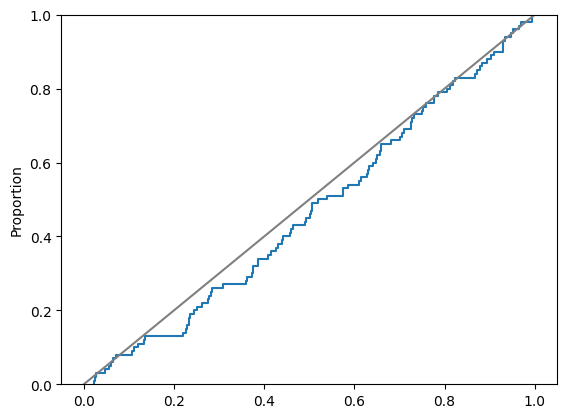

In [144]:
sns.ecdfplot(x=np.array(pval_ls_tilted[0]))
plt.plot([0., 1], [0., 1], color="grey")